# Objetivo:

A partir de orçamentos de projetos de freelance, isto é, quantidade de horas demandadas e preço, queremos prever se o projeto será finalizado ou não.

## Dados:

Cada linha representa um projeto de freelance que tem três atributos:
- **Unfinished**: 0 se o projeto foi finalizado, 1 caso não tenha sido finalizado.
- **Expected hours**: quantidade de horas estimadas pelo contratado para finalizar o projeto
- **Price**: O preço que foi cobrado pelo projeto

In [ ]:
import pandas as pd

uri = 'https://gist.githubusercontent.com/guilhermesilveira/1b7d5475863c15f484ac495bd70975cf/raw/16aff7a0aee67e7c100a2a48b676a2d2d142f646/projects.csv'
projects = pd.read_csv(uri)
projects.head()

,unfinished,expected_hours,price
0,1,26,192
1,1,88,9015
2,1,89,2577
3,1,42,275
4,1,39,170


## Pré processamento dos dados

Temos uma coluna que identifica se um projeto foi "não finalizado", mas trabalhar com negações fica menos legível, então vamos criar uma nova coluna que indica se o projeto foi finalizado (1) ou não (0), apenas invertendo os valores.

In [ ]:
unfinished_to_finished = {
    0 : 1,
    1 : 0
}
projects['finished'] = projects.unfinished.map(unfinished_to_finished)
projects.head()

,unfinished,expected_hours,price,finished
0,1,26,192,0
1,1,88,9015,0
2,1,89,2577,0
3,1,42,275,0
4,1,39,170,0


## Visualização dos dados

Vamos visualizar os dados para tentar identificar alguma relação.

<Axes: xlabel='expected_hours', ylabel='price'>

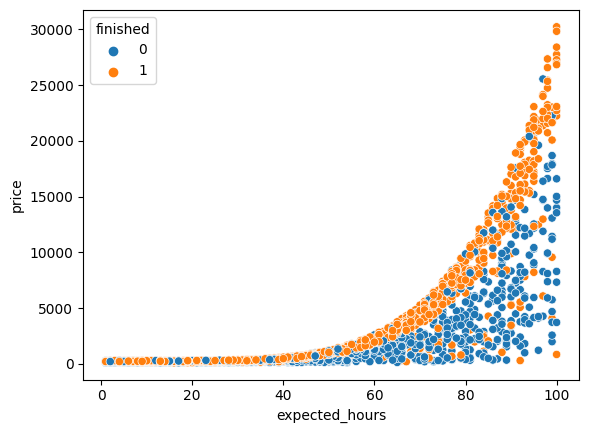

In [ ]:
import seaborn as sns

sns.scatterplot(x = "expected_hours", y = "price", hue = "finished", data = projects)

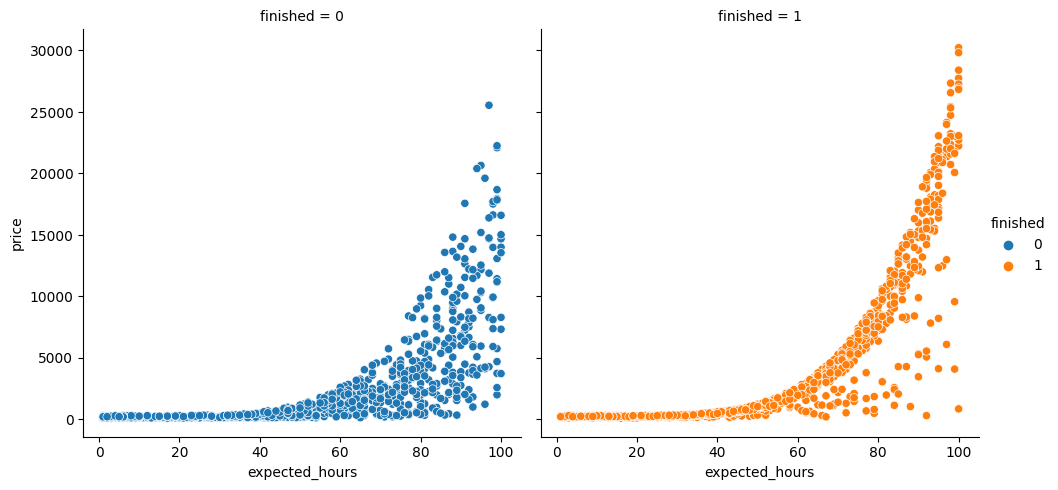

In [ ]:
sns.relplot(x = "expected_hours", y = "price", hue = "finished", col = "finished", data = projects)

Primeiramente, podemos ver que o preço dos projetos tendem a crescer de forma aparentemente exponencial conforme aumenta a quantidade de horas esperadas para sua execução.

Além disso, é possível ver que os projetos finalizados são os que têm um preço maior, provavelmente considerados mais justo. Entretanto, há projetos que são finalizados por um preço menor. Uma hipótese para isso é que algumas vezes, os projetos demandam menos horas do que de fato foram planejadas.

# Modelo de previsão

Vamos iniciar explorando diferentes modelos para ver a diferença entre a performance deles.

In [ ]:
# separando os dados entre features e labels para realizar a classificação
project_features = projects[['expected_hours', 'price']]
project_labels = projects['finished']

Import das bibliotecas e definição de um seed para garantir a reprodutibilidade dos resultados.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

SEED = 5
np.random.seed(SEED)

Separação dos dados entre treino e teste. Usando o stratify para garantir que os dados de treino e teste tenham a mesma distribuição de projetos finalizados e não finalizados.

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(project_features, project_labels,
                                                    test_size = 0.25,
                                                    stratify = project_labels)

print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(train_x), len(test_x)))

Treinaremos com 1617 elementos e testaremos com 540 elementos


## Modelo Linear

Primeiramente, vamos testar a eficiência de um modelo linear para fazer essa classificação.

In [ ]:
linear_model = LinearSVC(random_state = SEED)
linear_model.fit(train_x, train_y)
linear_predictions = linear_model.predict(test_x)

linear_accuracy = accuracy_score(test_y, linear_predictions) * 100
print("A acurácia do modelo linear foi %.2f%%" % linear_accuracy)

A acurácia do modelo linear foi 54.07%


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Para analisar se essa acurácia é boa ou não, vamos avaliar um modelo mais simples, chamado DummyClassifier, que será considerado o nosso "baseline" para a acurácia. Basicamente, ele "chuta" uma previsão baseada no valor mais frequente da amostra.

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_model = DummyClassifier(random_state = SEED)
dummy_model.fit(train_x, train_y)
dummy_accuracy = dummy_model.score(test_x, test_y) * 100

print("A acurácia do dummy foi %.2f%%" % dummy_accuracy)

A acurácia do dummy foi 52.59%


Podemos ver, então, que o modelo linear foi ligeiramente melhor que o Dummy. Mas vamos ver se conseguimos um desempenho ainda maior.

Para isso, vamos tentar entender visualmente como os dados estão sendo classificados.

Isso é possível de ser feito pois temos features com apenas duas dimensões, então a visualização fica muito facilitada.

Faremos isso plotando o que é chamado de Decision Boundary, ou seja, uma barreira que delimita os dados que vão ser classificados como finalizados ou não finalizados.

In [ ]:
# configurando os parâmetros para o gráfico

x_min = test_x.expected_hours.min()
x_max = test_x.expected_hours.max()
y_min = test_x.price.min()
y_max = test_x.price.max()

pixels = 100
axis_x = np.linspace(x_min, x_max, num = pixels)
axis_y = np.linspace(y_min, y_max, num = pixels)

mesh_x, mesh_y = np.meshgrid(axis_x, axis_y)
points = np.c_[mesh_x.ravel(), mesh_y.ravel()]
points

array([[1.0000e+00, 1.0000e+02],
       [2.0000e+00, 1.0000e+02],
       [3.0000e+00, 1.0000e+02],
       ...,
       [9.8000e+01, 3.0223e+04],
       [9.9000e+01, 3.0223e+04],
       [1.0000e+02, 3.0223e+04]])

Acima, criamos uma lista de pontos que preenchem toda uma parte de interesse do gráfico. Para construir a decision boundary, vamos classificar cada um desses pontos de acordo com nosso modelo.

In [ ]:
points_labels_linear = linear_model.predict(points)

points_labels_linear = points_labels_linear.reshape(mesh_x.shape)
points_labels_linear

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

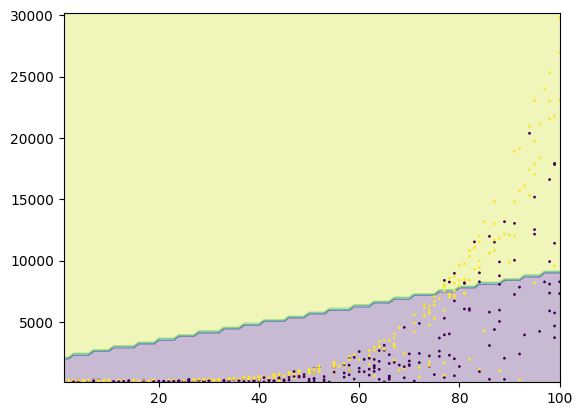

In [ ]:
import matplotlib.pyplot as plt

plt.contourf(mesh_x, mesh_y, points_labels_linear, alpha=0.3)
plt.scatter(test_x.expected_hours, test_x.price, c = test_y, s = 1)

# DECISION BOUNDARY

Como já foi mencionado, os dados tem um comportamento que parece ser exponencial. No modelo LinearSVC, a decision boundary é limitada a um formato linear, que podemos perceber visualmente que não é o mais adequado.

Vamos, então, usar um modelo não linear.

## Modelo Não Linear

In [ ]:
from sklearn.svm import SVC

non_linear_model = SVC()
non_linear_model.fit(train_x, train_y)
non_linear_predictions = non_linear_model.predict(test_x)

non_linear_accuracy = accuracy_score(test_y, non_linear_predictions) * 100
print("A acurácia foi %.2f%%" % non_linear_accuracy)

A acurácia foi 55.19%


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


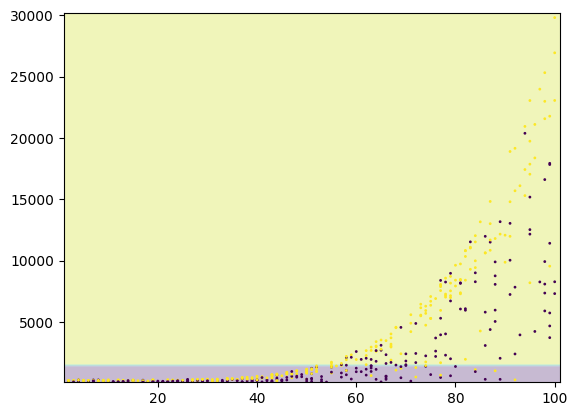

In [ ]:
points_labels_non_linear = non_linear_model.predict(points)
points_labels_non_linear = points_labels_non_linear.reshape(mesh_x.shape)

plt.contourf(mesh_x, mesh_y, points_labels_non_linear, alpha = 0.3)
plt.scatter(test_x.expected_hours, test_x.price, c = test_y, s = 1)

# DECISION BOUNDARY

Apesar da acurácia ter sido um pouco maior que o modelo linear, a decision boundary não foi a esperada intuitivamente.

O que acontece é que o SVC é sensível à escala dos dados. Então precisamos fazer uma normalização para que todos os eixos obedeçam uma mesma escala. Faremos isso usando a função StandardScaler do SKLearn

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_x)
normalized_train_x = scaler.transform(train_x)
normalized_test_x = scaler.transform(test_x)

non_linear_model = SVC()
non_linear_model.fit(normalized_train_x, train_y)
non_linear_predictions = non_linear_model.predict(normalized_test_x)

non_linear_accuracy = accuracy_score(test_y, non_linear_predictions) * 100
print("A acurácia foi %.2f%%" % non_linear_accuracy)

A acurácia foi 66.85%


Com isso conseguimos um aumento significativo da acurácia.

Vamos, então, plotar novamente a decision boundary

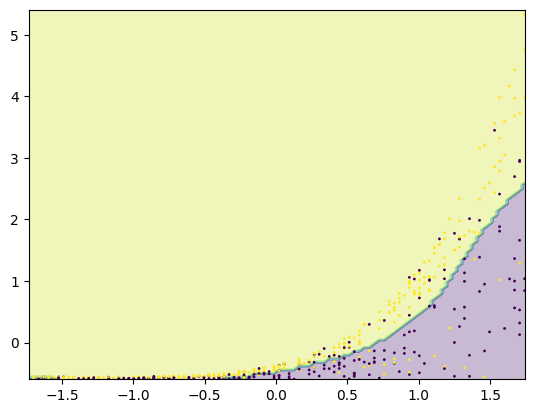

In [ ]:
x_min = normalized_test_x[:,0].min()
x_max = normalized_test_x[:,0].max()
y_min = normalized_test_x[:,1].min()
y_max = normalized_test_x[:,1].max()

pixels = 100
axis_x = np.linspace(x_min, x_max, num = pixels)
axis_y = np.linspace(y_min, y_max, num = pixels)

mesh_x, mesh_y = np.meshgrid(axis_x, axis_y)
pontos = np.c_[mesh_x.ravel(), mesh_y.ravel()]

points_labels_non_linear = non_linear_model.predict(pontos)
points_labels_non_linear = points_labels_non_linear.reshape(mesh_x.shape)

plt.contourf(mesh_x, mesh_y, points_labels_non_linear, alpha = 0.3)
plt.scatter(normalized_test_x[:,0], normalized_test_x[:,1], c = test_y, s = 1)

# DECISION BOUNDARY

Agora está com um formato que acompanha muito melhor o comportamento natural dos dados.

# Conclusão
Ao usar um modelo não linear com o tratamento correto dos dados, conseguimos um ganho de 14% de acurácia em relação a baseline. Pudemos ver como a decision boundary se alterou conforme o aumento da acurácia e como, ao final, ela estava bem de acordo com a linha que criaríamos intuitivamente para realizar essa decisão.

OBS: Projeto desenvolvido durante o curso "Machine Learning: Classificação com SKLearn" da Alura